In [1]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd
import cv2
import pickle
import configparser
import tempfile

Create functions that extract data from the S3 bucket and create a dataset from it. 

In [2]:
#Get S3 credentials from config file
config = configparser.ConfigParser()
config.read('S3.conf')
AWS_ACCESS_KEY_ID = config['DEFAULT']['AccessKeyId']
AWS_SECRET_ACCESS_KEY = config['DEFAULT']['AccessKeySecret']

In [3]:
#Access S3 bucket and get list of contents.
bucketName = 'miscdatastorage'
dataDir = 'DHSData/'
pickle_name = 'prelim_dataset.pickle'
np.random.seed(seed=0)

import boto3 

client = boto3.resource('s3',aws_access_key_id = AWS_ACCESS_KEY_ID ,
                      aws_secret_access_key= AWS_SECRET_ACCESS_KEY)
myBucket = client.Bucket(bucketName)
contents = [k.key for k in myBucket.objects.all()]
contents = contents[1:]#Remove initial empty key in the result set.
print("Total Items: {}".format(len(contents)))

Total Items: 1247


In [12]:
#Given image name, load, resize image and return image ndarray. 


def getResizedImage(path,new_dim):
    #Read
    img = iof.read_data(path)
    #Shift to usual range of img pixel value (0-255)
    img_min = np.amin(img)
    img_max = np.amax(img)
    img_shifted = (img-img_min)/(img_max-img_min)*255
    #Normalize 
    img_average = np.mean(img_shifted)
    img_std = np.std(img_shifted)
    img_norm = (img_shifted-img_average)/img_std
    #Resize
    return cv2.resize(img_norm,dsize = (new_dim,new_dim))

#Create dataset from img data.  If pct < 1 then randomly chose pct of images to create data set
def getData(bucket,labels_dir,pct = 1.0,new_dim = 300,angles = [0,8,16,24,32,40,48,56]):
    #Create dictionary in the form of {'img_name': label vector}
    labels = pd.read_csv(labels_dir)
    labels = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])] 
    labels_merged = iof.merge_17(labels) #Returns list of ids and corresponding list of zones
    labels_dict = {i:j for i,j in labels_merged}
    #Iterate through set of images and make a list of training data and another list of corresponding training labels
    image_keys = [k.key for k in myBucket.objects.all()]
    image_keys = image_keys[1:]#Remove initial empty key in the result set.
    #image_keys = ['DHSData/087d7648e320f02c2c41e029f6cc2cd0.a3daps']
    if pct < 1.0:
        image_keys = np.random.choice(image_keys,
                                       int(pct*len(image_keys)),replace=False)
    n_samples = len(image_keys)
    n_angles = len(angles)
    training_labels = np.zeros((n_samples,17))
    training_features = np.zeros((n_samples,new_dim,new_dim,n_angles))
    s = 0
    a = 0
    for image in image_keys:
        img_id = image.strip().replace('DHSData/','').replace('.a3daps','')
        try:
            training_labels[s,:] = np.array(labels_dict[img_id])
        except(KeyError):
            print("There is no label for image{}".format(img_id))
            continue
        tmp = tempfile.NamedTemporaryFile(suffix='.a3daps')
        with open(tmp.name,'wb') as f:
            bucket.download_fileobj(image,f)
            #img_array = getResizedImage(tmp.name,new_dim)
            try:
                img_array = getResizedImage(tmp.name,new_dim)
            except:
                print("Could not load image: {}".format(image))
                continue
        for angle in angles:
            training_features[s,:,:,a] = img_array[:,:,angle]
            a += 1
        s += 1
        a = 0
    return training_features, training_labels
def CreateDataSet(bucket,pct):
    labels_dir = r'stage1_labels.csv'
    features,labels = getData(bucket,labels_dir,pct=pct)
    save = {'labels':labels,'features':features}
    with open(pickle_name,"wb") as f:
        pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
        f.close()
    return
#image = 'DHSData/087d7648e320f02c2c41e029f6cc2cd0.a3daps'
CreateDataSet(myBucket,0.40)
#tmp = tempfile.NamedTemporaryFile(suffix='.a3daps')
#with open(tmp.name,'wb') as f:
   # myBucket.download_fileobj(image,f)
   # img_array = getResizedImage(tmp.name,300)


There is no label for imaged9b6081197ee70ebcaeabc8bf7749792
There is no label for imagebad6cac85809cbc9bc7c3d8dfd063841
Could not load image: DHSData/5cbbcb73ae6e7fa727d41b2787d91d6a.a3daps
Could not load image: DHSData/fcd7df5b42fcd420d03ac7bdec718195.a3daps
There is no label for image77fa6aa1e3c2ac6ec2c31457abcc2ca2
There is no label for imagead4a88206e1e7843b954997fa019cbe1
Could not load image: DHSData/9886ca52c028745ac6639989b937c6e8.a3daps
There is no label for image49c3fc4b14948ab097a3462bb825e2f0
Could not load image: DHSData/05709d5e54f8fdc77fe233cf7df78b81.a3daps
There is no label for imagebe0008e3e3ce57188aa0509d5a557ced
There is no label for imagecb4aad9898654da3b7a079837d452c7a
There is no label for image1b861c23fc370c326ec8342733ef5d84
There is no label for image6ec5ce5500d9ce14887e64f47486ad5f
There is no label for imagee0c39c6bf891474438bc44e05a953781
There is no label for image0fadb2ac7be1a0ed6fb7cd81372c18ba
There is no label for imageb9f49657be5a7c9da830c0ff75e497aa


Shape of feaures: (498, 300, 300, 8)
Shape of labels: (498, 17)


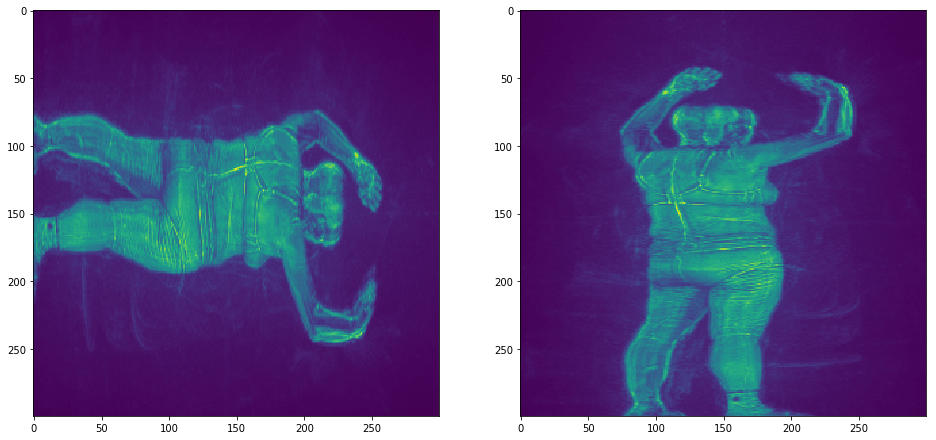

In [4]:
with open(pickle_name,"rb") as f:
    save = pickle.load(f)
    training_features = save['features']
    training_labels = save['labels']
print("Shape of feaures: {}".format(training_features.shape))
print("Shape of labels: {}".format(training_labels.shape))
#Make sure images look okay 
sample_num = 50
angle = 5
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(np.flipud(training_features[sample_num,:,:,angle].transpose()), cmap = 'viridis')
ax.imshow(training_features[sample_num,:,:,angle], cmap = 'viridis')

In [5]:
#Divide the data into train, test 
from sklearn.model_selection import train_test_split
training_features_rs = np.reshape(training_features,(training_features.shape[0],
                                             training_features.shape[1]*training_features.shape[2]*training_features.shape[3]))
X_train,X_test,y_train,y_test = train_test_split(training_features_rs,training_labels,random_state=0,train_size=0.80)


/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's train a randm forest classifier to get an estimate of the baseline performance we can achieve with a subset of the data, and the learning rate. 

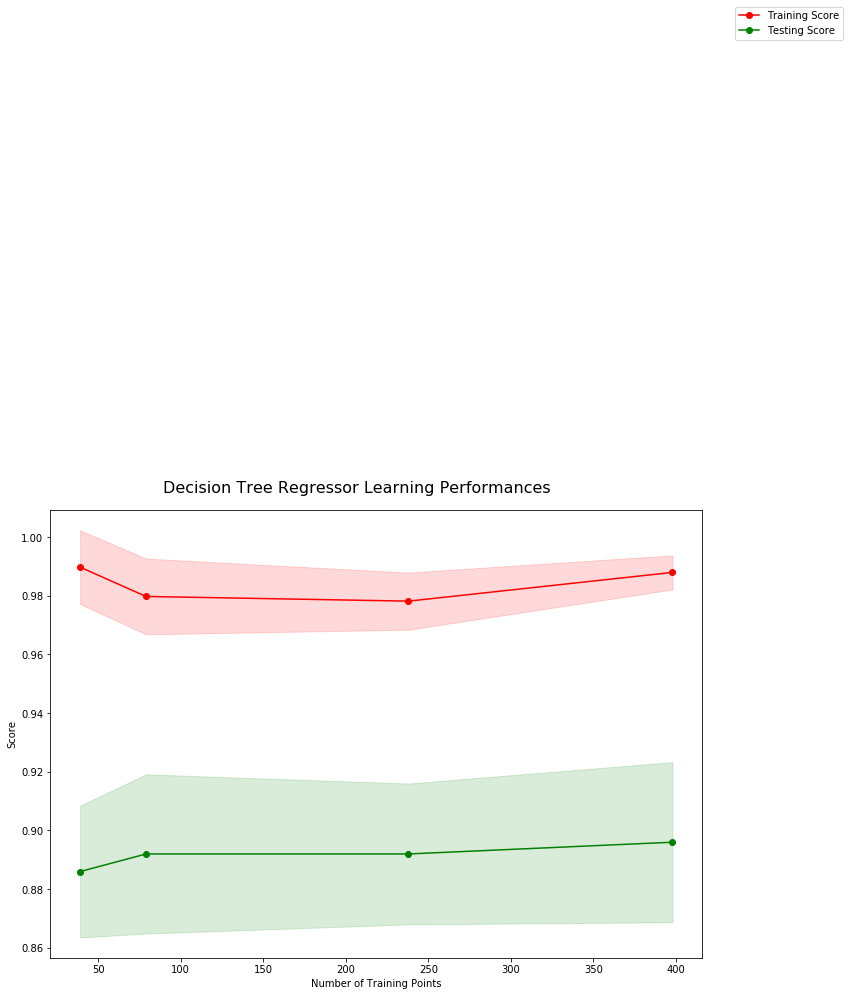

In [11]:
from sklearn.ensemble import RandomForestClassifier
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import numpy as np
import sklearn.learning_curve as curves
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer,log_loss


def ModelLearning(X, y,regressor,train_sizes):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 0)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))
    
    #Create log-loss scorer
    #ll_scorer = make_scorer(log_loss)
    
    # Calculate the training and testing scores
    sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
        cv = cv, train_sizes = train_sizes)

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve 
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    #ax.set_title('max_depth = %s'%(depth))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    #ax.set_xlim([0, X.shape[0]*0.8])
    #ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

clf = RandomForestClassifier()   
train_sizes = [0.10,0.20,0.60,1]
ModelLearning(training_features_rs,training_labels[:,0],clf,train_sizes)

In [14]:
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier()
clf.fit(X_train,y_train[:,0])
print("Train Score:{}".format(clf.score(X_train,y_train[:,0])))
print("Test score:{}".format(clf.score(X_test,y_test[:,0])))

Train Score:0.9798994974874372
Test score:0.92


Now, let's work on some dimensionality reduction techniques and see if the accuracy improves.

